In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\USER\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Import

In [2]:
#bring in the six packs
df_train = pd.read_csv('./house_train.csv')
print(df_train.shape)

(1460, 81)


In [3]:
df_test = pd.read_csv('./house_test.csv')
print(df_test.shape)

(1459, 80)


In [4]:
### 불필요 컬럼 제외
df_train.drop(['Id'], axis=1, inplace=True)
df_test .drop(['Id'], axis=1, inplace=True)

print(df_train.shape, df_test.shape)

(1460, 80) (1459, 79)


### Target Cleansing

In [5]:
df_train.reset_index(drop=True, inplace=True)

### log처리
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
y = df_train['SalePrice'].reset_index(drop=True)

print(df_train.shape, y .shape)

(1460, 80) (1460,)


In [6]:
train_features = df_train.drop(['SalePrice'], axis=1)
test_features = df_test
features = pd.concat([train_features, test_features]).reset_index(drop=True)

In [7]:
features.shape

(2919, 79)

### Data pre-processing

In [8]:
# Since these column are actually a category , using a numerical number will lead the model to assume
# that it is numerical , so we convert to string .
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

## Filling these columns With most suitable value for these columns 
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")

## Filling these with MODE , i.e. , the most frequent value in these columns .
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

In [9]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')

### Same with basement
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

In [10]:
features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [11]:
objects = []

for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)
features.update(features[objects].fillna('None'))
print(objects)

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [12]:
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))
numerics[1:10]

['LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF']

### Feature Engineering

In [13]:
import numpy as np
from scipy.stats import skew, kurtosis, boxcox_normmax
from scipy.special import boxcox1p
from scipy import stats

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

In [14]:
# Removing features that are not very useful . This can be understood only by doing proper EDA on data
features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)


# Adding new features . Make sure that you understand this. 

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [15]:
## For ex, if PoolArea = 0 , Then HasPool = 0 too - Flagging

features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [16]:
features.shape

(2919, 86)

In [17]:
final_features = pd.get_dummies(features).reset_index(drop=True)
final_features.shape

(2919, 334)

In [18]:
X = final_features.iloc[:len(y), :]
#X_sub = final_features.iloc[len(y):, :]
X_test = final_features.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((1460, 334), (1460,), (1459, 334))

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1022, 334) (438, 334) (1022,) (438,)


### Modeling

### Basic

In [20]:
from lightgbm import LGBMRegressor

LGBM = LGBMRegressor(n_estimators = 200)
LGBM.fit(x_train,y_train)

LGBMRegressor(n_estimators=200)

In [21]:
y_train_pred_x = LGBM.predict(x_train)
y_test_pred_x = LGBM.predict(x_test)

### 평가지표

In [22]:
from sklearn.metrics import mean_squared_error #Mean squared error regression loss.
from sklearn.model_selection import cross_val_score
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=X):
    rmse = np.sqrt(cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    return (rmse)

def RMSE (y,pred):
    return np.sqrt(np.mean(np.square(y - pred)))

In [23]:
from sklearn.metrics import mean_absolute_error

print('rmsle Train = ' + str(rmsle(y_train, y_train_pred_x)))
print('rmsle Test = ' + str(rmsle(y_test, y_test_pred_x)))
print("Mean Absolute Error Train : " + str(mean_absolute_error(y_train, y_train_pred_x)))
print("Mean Absolute Error Test : " + str(mean_absolute_error(y_test, y_test_pred_x)))
print("RMSE Train" , RMSE(y_train ,  y_train_pred_x))
print("RMSE Test" , RMSE(y_test , y_test_pred_x))

rmsle Train = 0.022020140906316574
rmsle Test = 0.14184944055042473
Mean Absolute Error Train : 0.009910523563398185
Mean Absolute Error Test : 0.09079764923994098
RMSE Train 0.02202014090631656
RMSE Test 0.14184944055042475


•Xgboost
•rmsle Train = 0.06316485133300465
•rmsle Test = 0.13704960992312681
•Mean Absolute Error Train : 0.04625574580373437
•Mean Absolute Error Test : 0.0886743783893323
•RMSE Train 133.1366069331883
•RMSE Test 0.13704960992312681

### Hyper parameter tuning

In [24]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth': [5, 7, 10],
          'min_child_samples': [20, 40],
          'subsample': [0.8, 1]}

LGBM = LGBMRegressor()
grid = GridSearchCV(LGBM , param_grid=params)
grid.fit(x_train, y_train, early_stopping_rounds=100, eval_set=[(x_train, y_train), (x_test, y_test)])

[1]	valid_0's l2: 0.131684	valid_1's l2: 0.145171
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.111678	valid_1's l2: 0.125574
[3]	valid_0's l2: 0.0953645	valid_1's l2: 0.10938
[4]	valid_0's l2: 0.0817073	valid_1's l2: 0.0958668
[5]	valid_0's l2: 0.0703147	valid_1's l2: 0.0847543
[6]	valid_0's l2: 0.0611596	valid_1's l2: 0.0759451
[7]	valid_0's l2: 0.0535575	valid_1's l2: 0.0687402
[8]	valid_0's l2: 0.0470341	valid_1's l2: 0.0623169
[9]	valid_0's l2: 0.0416538	valid_1's l2: 0.0573613
[10]	valid_0's l2: 0.0367527	valid_1's l2: 0.0520841
[11]	valid_0's l2: 0.0326996	valid_1's l2: 0.0479196
[12]	valid_0's l2: 0.0293236	valid_1's l2: 0.0444884
[13]	valid_0's l2: 0.0265641	valid_1's l2: 0.0416394
[14]	valid_0's l2: 0.024136	valid_1's l2: 0.039149
[15]	valid_0's l2: 0.0221529	valid_1's l2: 0.0370495
[16]	valid_0's l2: 0.0204679	valid_1's l2: 0.0351697
[17]	valid_0's l2: 0.0190702	valid_1's l2: 0.0335491
[18]	valid_0's l2: 0.0179115	valid_1's l2: 0.0321736
[

[1]	valid_0's l2: 0.131921	valid_1's l2: 0.146243
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.112081	valid_1's l2: 0.126902
[3]	valid_0's l2: 0.0959233	valid_1's l2: 0.111167
[4]	valid_0's l2: 0.0824729	valid_1's l2: 0.0974541
[5]	valid_0's l2: 0.0713017	valid_1's l2: 0.0861231
[6]	valid_0's l2: 0.0620225	valid_1's l2: 0.076884
[7]	valid_0's l2: 0.0542872	valid_1's l2: 0.0693174
[8]	valid_0's l2: 0.0479108	valid_1's l2: 0.0629849
[9]	valid_0's l2: 0.042594	valid_1's l2: 0.0575652
[10]	valid_0's l2: 0.038202	valid_1's l2: 0.0536859
[11]	valid_0's l2: 0.0340367	valid_1's l2: 0.0494936
[12]	valid_0's l2: 0.030583	valid_1's l2: 0.0459833
[13]	valid_0's l2: 0.0276895	valid_1's l2: 0.0428232
[14]	valid_0's l2: 0.0253216	valid_1's l2: 0.0401468
[15]	valid_0's l2: 0.023204	valid_1's l2: 0.0379193
[16]	valid_0's l2: 0.0213968	valid_1's l2: 0.036103
[17]	valid_0's l2: 0.0199988	valid_1's l2: 0.0344368
[18]	valid_0's l2: 0.0187406	valid_1's l2: 0.0331906
[19]

[72]	valid_0's l2: 0.00772619	valid_1's l2: 0.0213328
[73]	valid_0's l2: 0.0076222	valid_1's l2: 0.021337
[74]	valid_0's l2: 0.00759047	valid_1's l2: 0.0213014
[75]	valid_0's l2: 0.0075447	valid_1's l2: 0.0212962
[76]	valid_0's l2: 0.0074653	valid_1's l2: 0.0213284
[77]	valid_0's l2: 0.00743685	valid_1's l2: 0.0213225
[78]	valid_0's l2: 0.00739941	valid_1's l2: 0.0212925
[79]	valid_0's l2: 0.007357	valid_1's l2: 0.021241
[80]	valid_0's l2: 0.00729892	valid_1's l2: 0.0212263
[81]	valid_0's l2: 0.00726672	valid_1's l2: 0.0211653
[82]	valid_0's l2: 0.00722248	valid_1's l2: 0.0211356
[83]	valid_0's l2: 0.00719999	valid_1's l2: 0.0211104
[84]	valid_0's l2: 0.00714804	valid_1's l2: 0.0210798
[85]	valid_0's l2: 0.00711349	valid_1's l2: 0.0210904
[86]	valid_0's l2: 0.00707892	valid_1's l2: 0.021085
[87]	valid_0's l2: 0.00699727	valid_1's l2: 0.021053
[88]	valid_0's l2: 0.00697426	valid_1's l2: 0.0210661
[89]	valid_0's l2: 0.00694143	valid_1's l2: 0.0210514
[90]	valid_0's l2: 0.00692668	valid_1

[97]	valid_0's l2: 0.0066734	valid_1's l2: 0.0205122
[98]	valid_0's l2: 0.00665978	valid_1's l2: 0.0205641
[99]	valid_0's l2: 0.00659769	valid_1's l2: 0.0205098
[100]	valid_0's l2: 0.00657626	valid_1's l2: 0.020522
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00657626	valid_1's l2: 0.020522
[1]	valid_0's l2: 0.13128	valid_1's l2: 0.143675
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.11143	valid_1's l2: 0.12444
[3]	valid_0's l2: 0.0949214	valid_1's l2: 0.107587
[4]	valid_0's l2: 0.0813138	valid_1's l2: 0.094865
[5]	valid_0's l2: 0.0701341	valid_1's l2: 0.0839876
[6]	valid_0's l2: 0.0608772	valid_1's l2: 0.075377
[7]	valid_0's l2: 0.0532295	valid_1's l2: 0.0675925
[8]	valid_0's l2: 0.046775	valid_1's l2: 0.0610049
[9]	valid_0's l2: 0.041394	valid_1's l2: 0.0557865
[10]	valid_0's l2: 0.0371377	valid_1's l2: 0.0513003
[11]	valid_0's l2: 0.0332288	valid_1's l2: 0.0477452
[12]	valid_0's l2: 0.0296893	valid_1's l2: 0.0440672
[13]	v

[1]	valid_0's l2: 0.131464	valid_1's l2: 0.145552
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.111681	valid_1's l2: 0.125561
[3]	valid_0's l2: 0.0950317	valid_1's l2: 0.10973
[4]	valid_0's l2: 0.081233	valid_1's l2: 0.0967779
[5]	valid_0's l2: 0.0699724	valid_1's l2: 0.0857437
[6]	valid_0's l2: 0.060854	valid_1's l2: 0.0766336
[7]	valid_0's l2: 0.052987	valid_1's l2: 0.0688954
[8]	valid_0's l2: 0.0466536	valid_1's l2: 0.0626879
[9]	valid_0's l2: 0.041379	valid_1's l2: 0.0572111
[10]	valid_0's l2: 0.0365677	valid_1's l2: 0.0523803
[11]	valid_0's l2: 0.0330166	valid_1's l2: 0.0487141
[12]	valid_0's l2: 0.0296422	valid_1's l2: 0.0451092
[13]	valid_0's l2: 0.0267919	valid_1's l2: 0.0422295
[14]	valid_0's l2: 0.024364	valid_1's l2: 0.0395412
[15]	valid_0's l2: 0.0225473	valid_1's l2: 0.0374572
[16]	valid_0's l2: 0.0208555	valid_1's l2: 0.0355861
[17]	valid_0's l2: 0.0195776	valid_1's l2: 0.0341253
[18]	valid_0's l2: 0.018289	valid_1's l2: 0.0327828
[19]	

[84]	valid_0's l2: 0.0073772	valid_1's l2: 0.0210728
[85]	valid_0's l2: 0.00735297	valid_1's l2: 0.021091
[86]	valid_0's l2: 0.00728361	valid_1's l2: 0.0210572
[87]	valid_0's l2: 0.00724311	valid_1's l2: 0.0210209
[88]	valid_0's l2: 0.00722953	valid_1's l2: 0.0210462
[89]	valid_0's l2: 0.00720311	valid_1's l2: 0.0209954
[90]	valid_0's l2: 0.007165	valid_1's l2: 0.0210549
[91]	valid_0's l2: 0.00711946	valid_1's l2: 0.0210182
[92]	valid_0's l2: 0.00708333	valid_1's l2: 0.0210128
[93]	valid_0's l2: 0.0070634	valid_1's l2: 0.0209828
[94]	valid_0's l2: 0.00702963	valid_1's l2: 0.0210047
[95]	valid_0's l2: 0.00700965	valid_1's l2: 0.0210069
[96]	valid_0's l2: 0.00698647	valid_1's l2: 0.0210008
[97]	valid_0's l2: 0.00696543	valid_1's l2: 0.0209915
[98]	valid_0's l2: 0.0069487	valid_1's l2: 0.0210168
[99]	valid_0's l2: 0.00693262	valid_1's l2: 0.0210084
[100]	valid_0's l2: 0.00690376	valid_1's l2: 0.0210057
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00690376	valid_1'

[100]	valid_0's l2: 0.00833532	valid_1's l2: 0.0215747
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00833532	valid_1's l2: 0.0215747
[1]	valid_0's l2: 0.132991	valid_1's l2: 0.146839
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.114341	valid_1's l2: 0.128475
[3]	valid_0's l2: 0.0987255	valid_1's l2: 0.113253
[4]	valid_0's l2: 0.085912	valid_1's l2: 0.10062
[5]	valid_0's l2: 0.0749526	valid_1's l2: 0.0896244
[6]	valid_0's l2: 0.0660903	valid_1's l2: 0.0810586
[7]	valid_0's l2: 0.0586412	valid_1's l2: 0.0739559
[8]	valid_0's l2: 0.0523351	valid_1's l2: 0.0677877
[9]	valid_0's l2: 0.0465926	valid_1's l2: 0.0620163
[10]	valid_0's l2: 0.0417885	valid_1's l2: 0.0573107
[11]	valid_0's l2: 0.0380772	valid_1's l2: 0.0537557
[12]	valid_0's l2: 0.0345334	valid_1's l2: 0.050079
[13]	valid_0's l2: 0.0316148	valid_1's l2: 0.0469718
[14]	valid_0's l2: 0.0291248	valid_1's l2: 0.0443038
[15]	valid_0's l2: 0.026941	valid_1's l2: 0.0420687
[16]

[96]	valid_0's l2: 0.0089224	valid_1's l2: 0.0209206
[97]	valid_0's l2: 0.00888797	valid_1's l2: 0.020909
[98]	valid_0's l2: 0.00886933	valid_1's l2: 0.0208744
[99]	valid_0's l2: 0.00884465	valid_1's l2: 0.0208704
[100]	valid_0's l2: 0.00880028	valid_1's l2: 0.0208497
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00880028	valid_1's l2: 0.0208497
[1]	valid_0's l2: 0.132407	valid_1's l2: 0.146314
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113435	valid_1's l2: 0.127657
[3]	valid_0's l2: 0.0976552	valid_1's l2: 0.112106
[4]	valid_0's l2: 0.0844042	valid_1's l2: 0.0989377
[5]	valid_0's l2: 0.0735734	valid_1's l2: 0.0880781
[6]	valid_0's l2: 0.0645148	valid_1's l2: 0.0794346
[7]	valid_0's l2: 0.0564894	valid_1's l2: 0.0719324
[8]	valid_0's l2: 0.0498465	valid_1's l2: 0.0656602
[9]	valid_0's l2: 0.0443994	valid_1's l2: 0.0602902
[10]	valid_0's l2: 0.0400693	valid_1's l2: 0.0561001
[11]	valid_0's l2: 0.0362518	valid_1's l2: 0.05274

[1]	valid_0's l2: 0.132655	valid_1's l2: 0.145478
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.11353	valid_1's l2: 0.127109
[3]	valid_0's l2: 0.0977174	valid_1's l2: 0.111516
[4]	valid_0's l2: 0.0845676	valid_1's l2: 0.098256
[5]	valid_0's l2: 0.0736777	valid_1's l2: 0.0875025
[6]	valid_0's l2: 0.0645585	valid_1's l2: 0.078489
[7]	valid_0's l2: 0.0569451	valid_1's l2: 0.071278
[8]	valid_0's l2: 0.0503989	valid_1's l2: 0.0648961
[9]	valid_0's l2: 0.0451448	valid_1's l2: 0.0596063
[10]	valid_0's l2: 0.0403114	valid_1's l2: 0.0550753
[11]	valid_0's l2: 0.036329	valid_1's l2: 0.0510172
[12]	valid_0's l2: 0.0330569	valid_1's l2: 0.0476208
[13]	valid_0's l2: 0.0301248	valid_1's l2: 0.0444709
[14]	valid_0's l2: 0.0274476	valid_1's l2: 0.0416155
[15]	valid_0's l2: 0.0253339	valid_1's l2: 0.0392905
[16]	valid_0's l2: 0.023661	valid_1's l2: 0.0375569
[17]	valid_0's l2: 0.0221394	valid_1's l2: 0.0359995
[18]	valid_0's l2: 0.0208553	valid_1's l2: 0.0344769
[19]

[1]	valid_0's l2: 0.132632	valid_1's l2: 0.146545
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.114033	valid_1's l2: 0.128574
[3]	valid_0's l2: 0.0982079	valid_1's l2: 0.112945
[4]	valid_0's l2: 0.0849525	valid_1's l2: 0.100033
[5]	valid_0's l2: 0.0741191	valid_1's l2: 0.0896406
[6]	valid_0's l2: 0.0649775	valid_1's l2: 0.0806306
[7]	valid_0's l2: 0.0577238	valid_1's l2: 0.0732766
[8]	valid_0's l2: 0.0513269	valid_1's l2: 0.066914
[9]	valid_0's l2: 0.0456683	valid_1's l2: 0.0612388
[10]	valid_0's l2: 0.0409531	valid_1's l2: 0.0562107
[11]	valid_0's l2: 0.0369693	valid_1's l2: 0.0523915
[12]	valid_0's l2: 0.0336735	valid_1's l2: 0.0489263
[13]	valid_0's l2: 0.0309435	valid_1's l2: 0.0460618
[14]	valid_0's l2: 0.0284402	valid_1's l2: 0.0434267
[15]	valid_0's l2: 0.0264646	valid_1's l2: 0.0412649
[16]	valid_0's l2: 0.0246304	valid_1's l2: 0.039108
[17]	valid_0's l2: 0.0231788	valid_1's l2: 0.0373777
[18]	valid_0's l2: 0.0218772	valid_1's l2: 0.0360342
[

[1]	valid_0's l2: 0.13129	valid_1's l2: 0.144838
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.111044	valid_1's l2: 0.124821
[3]	valid_0's l2: 0.0944418	valid_1's l2: 0.108929
[4]	valid_0's l2: 0.0804645	valid_1's l2: 0.0950014
[5]	valid_0's l2: 0.0689365	valid_1's l2: 0.0838126
[6]	valid_0's l2: 0.0596455	valid_1's l2: 0.0745471
[7]	valid_0's l2: 0.0518069	valid_1's l2: 0.0671197
[8]	valid_0's l2: 0.0452778	valid_1's l2: 0.0607414
[9]	valid_0's l2: 0.0398193	valid_1's l2: 0.0555885
[10]	valid_0's l2: 0.0353166	valid_1's l2: 0.051141
[11]	valid_0's l2: 0.0316246	valid_1's l2: 0.0473982
[12]	valid_0's l2: 0.0282402	valid_1's l2: 0.043801
[13]	valid_0's l2: 0.0254863	valid_1's l2: 0.0410053
[14]	valid_0's l2: 0.0230809	valid_1's l2: 0.0384162
[15]	valid_0's l2: 0.0211519	valid_1's l2: 0.0363758
[16]	valid_0's l2: 0.0193737	valid_1's l2: 0.0344988
[17]	valid_0's l2: 0.0179248	valid_1's l2: 0.0329686
[18]	valid_0's l2: 0.0167852	valid_1's l2: 0.0316275
[

[70]	valid_0's l2: 0.00671606	valid_1's l2: 0.0220868
[71]	valid_0's l2: 0.00664775	valid_1's l2: 0.0220693
[72]	valid_0's l2: 0.00661474	valid_1's l2: 0.0220662
[73]	valid_0's l2: 0.00658332	valid_1's l2: 0.0221106
[74]	valid_0's l2: 0.00656774	valid_1's l2: 0.022064
[75]	valid_0's l2: 0.00655629	valid_1's l2: 0.0220636
[76]	valid_0's l2: 0.00654362	valid_1's l2: 0.0220725
[77]	valid_0's l2: 0.00651801	valid_1's l2: 0.0220638
[78]	valid_0's l2: 0.00645235	valid_1's l2: 0.0220727
[79]	valid_0's l2: 0.0064279	valid_1's l2: 0.0220625
[80]	valid_0's l2: 0.00638985	valid_1's l2: 0.0221026
[81]	valid_0's l2: 0.00636695	valid_1's l2: 0.0221069
[82]	valid_0's l2: 0.00635608	valid_1's l2: 0.0221718
[83]	valid_0's l2: 0.0063314	valid_1's l2: 0.0221678
[84]	valid_0's l2: 0.00630908	valid_1's l2: 0.0221496
[85]	valid_0's l2: 0.00629692	valid_1's l2: 0.0221762
[86]	valid_0's l2: 0.00629341	valid_1's l2: 0.0221673
[87]	valid_0's l2: 0.0062779	valid_1's l2: 0.0221294
[88]	valid_0's l2: 0.00625392	va

[40]	valid_0's l2: 0.00872171	valid_1's l2: 0.0227485
[41]	valid_0's l2: 0.0086008	valid_1's l2: 0.022537
[42]	valid_0's l2: 0.00848395	valid_1's l2: 0.0224207
[43]	valid_0's l2: 0.00835759	valid_1's l2: 0.0222801
[44]	valid_0's l2: 0.00824936	valid_1's l2: 0.0221065
[45]	valid_0's l2: 0.00819133	valid_1's l2: 0.021984
[46]	valid_0's l2: 0.00809042	valid_1's l2: 0.0218227
[47]	valid_0's l2: 0.0079809	valid_1's l2: 0.0217432
[48]	valid_0's l2: 0.00789878	valid_1's l2: 0.0216997
[49]	valid_0's l2: 0.00784188	valid_1's l2: 0.0216813
[50]	valid_0's l2: 0.00775348	valid_1's l2: 0.0216033
[51]	valid_0's l2: 0.00768599	valid_1's l2: 0.0215649
[52]	valid_0's l2: 0.00761995	valid_1's l2: 0.0215617
[53]	valid_0's l2: 0.00754551	valid_1's l2: 0.0214534
[54]	valid_0's l2: 0.00741575	valid_1's l2: 0.0213601
[55]	valid_0's l2: 0.0073466	valid_1's l2: 0.0213147
[56]	valid_0's l2: 0.00726179	valid_1's l2: 0.0212402
[57]	valid_0's l2: 0.00719553	valid_1's l2: 0.0212494
[58]	valid_0's l2: 0.00715108	val

[2]	valid_0's l2: 0.111044	valid_1's l2: 0.124821
[3]	valid_0's l2: 0.0944418	valid_1's l2: 0.108929
[4]	valid_0's l2: 0.0804645	valid_1's l2: 0.0950014
[5]	valid_0's l2: 0.0689365	valid_1's l2: 0.0838126
[6]	valid_0's l2: 0.0596455	valid_1's l2: 0.0745471
[7]	valid_0's l2: 0.0518069	valid_1's l2: 0.0671197
[8]	valid_0's l2: 0.0452778	valid_1's l2: 0.0607414
[9]	valid_0's l2: 0.0398193	valid_1's l2: 0.0555885
[10]	valid_0's l2: 0.0353166	valid_1's l2: 0.051141
[11]	valid_0's l2: 0.0316246	valid_1's l2: 0.0473982
[12]	valid_0's l2: 0.0282402	valid_1's l2: 0.043801
[13]	valid_0's l2: 0.0254863	valid_1's l2: 0.0410053
[14]	valid_0's l2: 0.0230809	valid_1's l2: 0.0384162
[15]	valid_0's l2: 0.0211519	valid_1's l2: 0.0363758
[16]	valid_0's l2: 0.0193737	valid_1's l2: 0.0344988
[17]	valid_0's l2: 0.0179248	valid_1's l2: 0.0329686
[18]	valid_0's l2: 0.0167852	valid_1's l2: 0.0316275
[19]	valid_0's l2: 0.015704	valid_1's l2: 0.0305221
[20]	valid_0's l2: 0.0148111	valid_1's l2: 0.0294654
[21]	va

[96]	valid_0's l2: 0.00605521	valid_1's l2: 0.0220207
[97]	valid_0's l2: 0.00604219	valid_1's l2: 0.0220205
[98]	valid_0's l2: 0.00602027	valid_1's l2: 0.0220223
[99]	valid_0's l2: 0.00600574	valid_1's l2: 0.0219981
[100]	valid_0's l2: 0.00597796	valid_1's l2: 0.0220161
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00597796	valid_1's l2: 0.0220161
[1]	valid_0's l2: 0.131223	valid_1's l2: 0.14541
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.111011	valid_1's l2: 0.125858
[3]	valid_0's l2: 0.0945723	valid_1's l2: 0.110103
[4]	valid_0's l2: 0.0808233	valid_1's l2: 0.096245
[5]	valid_0's l2: 0.0695973	valid_1's l2: 0.0846121
[6]	valid_0's l2: 0.0602323	valid_1's l2: 0.0755607
[7]	valid_0's l2: 0.0524306	valid_1's l2: 0.0681304
[8]	valid_0's l2: 0.0460356	valid_1's l2: 0.0618247
[9]	valid_0's l2: 0.040609	valid_1's l2: 0.056373
[10]	valid_0's l2: 0.0360829	valid_1's l2: 0.0522239
[11]	valid_0's l2: 0.0322408	valid_1's l2: 0.0485825

[79]	valid_0's l2: 0.00624327	valid_1's l2: 0.020152
[80]	valid_0's l2: 0.00618321	valid_1's l2: 0.020121
[81]	valid_0's l2: 0.00615542	valid_1's l2: 0.0200937
[82]	valid_0's l2: 0.0061249	valid_1's l2: 0.0200428
[83]	valid_0's l2: 0.0061108	valid_1's l2: 0.0200295
[84]	valid_0's l2: 0.00608803	valid_1's l2: 0.0200253
[85]	valid_0's l2: 0.00605794	valid_1's l2: 0.0200202
[86]	valid_0's l2: 0.00602535	valid_1's l2: 0.0200172
[87]	valid_0's l2: 0.00600717	valid_1's l2: 0.0200078
[88]	valid_0's l2: 0.0059785	valid_1's l2: 0.0199807
[89]	valid_0's l2: 0.00594742	valid_1's l2: 0.0199593
[90]	valid_0's l2: 0.00592267	valid_1's l2: 0.0199588
[91]	valid_0's l2: 0.00591161	valid_1's l2: 0.0199818
[92]	valid_0's l2: 0.00587598	valid_1's l2: 0.0199415
[93]	valid_0's l2: 0.00583185	valid_1's l2: 0.0200016
[94]	valid_0's l2: 0.00580611	valid_1's l2: 0.0199527
[95]	valid_0's l2: 0.00579341	valid_1's l2: 0.01999
[96]	valid_0's l2: 0.00576789	valid_1's l2: 0.0199483
[97]	valid_0's l2: 0.00571041	valid

[36]	valid_0's l2: 0.0124391	valid_1's l2: 0.0248995
[37]	valid_0's l2: 0.0122746	valid_1's l2: 0.0246927
[38]	valid_0's l2: 0.0121283	valid_1's l2: 0.0245635
[39]	valid_0's l2: 0.0120134	valid_1's l2: 0.0244429
[40]	valid_0's l2: 0.0118745	valid_1's l2: 0.0242866
[41]	valid_0's l2: 0.0117444	valid_1's l2: 0.0241415
[42]	valid_0's l2: 0.0116358	valid_1's l2: 0.0239486
[43]	valid_0's l2: 0.0115146	valid_1's l2: 0.0238145
[44]	valid_0's l2: 0.0114124	valid_1's l2: 0.0236949
[45]	valid_0's l2: 0.0113038	valid_1's l2: 0.0236085
[46]	valid_0's l2: 0.011198	valid_1's l2: 0.0235124
[47]	valid_0's l2: 0.0110914	valid_1's l2: 0.0233667
[48]	valid_0's l2: 0.0110023	valid_1's l2: 0.0233174
[49]	valid_0's l2: 0.0108773	valid_1's l2: 0.0232626
[50]	valid_0's l2: 0.0108109	valid_1's l2: 0.0232053
[51]	valid_0's l2: 0.0106775	valid_1's l2: 0.0231064
[52]	valid_0's l2: 0.0106167	valid_1's l2: 0.0230536
[53]	valid_0's l2: 0.0105175	valid_1's l2: 0.0230198
[54]	valid_0's l2: 0.0104466	valid_1's l2: 0.02

[1]	valid_0's l2: 0.132862	valid_1's l2: 0.146661
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.114219	valid_1's l2: 0.128306
[3]	valid_0's l2: 0.0984217	valid_1's l2: 0.112948
[4]	valid_0's l2: 0.0854839	valid_1's l2: 0.1002
[5]	valid_0's l2: 0.0745398	valid_1's l2: 0.0892528
[6]	valid_0's l2: 0.0655076	valid_1's l2: 0.0807147
[7]	valid_0's l2: 0.0582224	valid_1's l2: 0.0736542
[8]	valid_0's l2: 0.0518179	valid_1's l2: 0.0670873
[9]	valid_0's l2: 0.0464937	valid_1's l2: 0.0621193
[10]	valid_0's l2: 0.0417151	valid_1's l2: 0.0571739
[11]	valid_0's l2: 0.0375837	valid_1's l2: 0.0530255
[12]	valid_0's l2: 0.0342649	valid_1's l2: 0.0495526
[13]	valid_0's l2: 0.031254	valid_1's l2: 0.046395
[14]	valid_0's l2: 0.0288059	valid_1's l2: 0.0438861
[15]	valid_0's l2: 0.0267571	valid_1's l2: 0.0416485
[16]	valid_0's l2: 0.0248938	valid_1's l2: 0.0396522
[17]	valid_0's l2: 0.0232949	valid_1's l2: 0.037931
[18]	valid_0's l2: 0.0219085	valid_1's l2: 0.0364079
[19]

[1]	valid_0's l2: 0.132407	valid_1's l2: 0.146314
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113391	valid_1's l2: 0.127669
[3]	valid_0's l2: 0.097614	valid_1's l2: 0.112116
[4]	valid_0's l2: 0.084288	valid_1's l2: 0.0989055
[5]	valid_0's l2: 0.0733706	valid_1's l2: 0.0879119
[6]	valid_0's l2: 0.0642575	valid_1's l2: 0.0791786
[7]	valid_0's l2: 0.0562884	valid_1's l2: 0.0716138
[8]	valid_0's l2: 0.0497079	valid_1's l2: 0.065509
[9]	valid_0's l2: 0.0443671	valid_1's l2: 0.0605388
[10]	valid_0's l2: 0.0398226	valid_1's l2: 0.0560633
[11]	valid_0's l2: 0.0360234	valid_1's l2: 0.0522067
[12]	valid_0's l2: 0.0327219	valid_1's l2: 0.0483834
[13]	valid_0's l2: 0.029951	valid_1's l2: 0.0455181
[14]	valid_0's l2: 0.0275582	valid_1's l2: 0.0429891
[15]	valid_0's l2: 0.0254808	valid_1's l2: 0.0406232
[16]	valid_0's l2: 0.0237917	valid_1's l2: 0.0386929
[17]	valid_0's l2: 0.02245	valid_1's l2: 0.0371588
[18]	valid_0's l2: 0.0211923	valid_1's l2: 0.0355775
[19]

[14]	valid_0's l2: 0.0269074	valid_1's l2: 0.0414466
[15]	valid_0's l2: 0.0247657	valid_1's l2: 0.0391171
[16]	valid_0's l2: 0.0230304	valid_1's l2: 0.0372231
[17]	valid_0's l2: 0.0214586	valid_1's l2: 0.0355016
[18]	valid_0's l2: 0.0201977	valid_1's l2: 0.034125
[19]	valid_0's l2: 0.0190815	valid_1's l2: 0.0327935
[20]	valid_0's l2: 0.0180728	valid_1's l2: 0.0316916
[21]	valid_0's l2: 0.017215	valid_1's l2: 0.0307786
[22]	valid_0's l2: 0.0165255	valid_1's l2: 0.0300286
[23]	valid_0's l2: 0.0158552	valid_1's l2: 0.0292153
[24]	valid_0's l2: 0.015237	valid_1's l2: 0.0285695
[25]	valid_0's l2: 0.014725	valid_1's l2: 0.0279939
[26]	valid_0's l2: 0.0142902	valid_1's l2: 0.0274361
[27]	valid_0's l2: 0.0138978	valid_1's l2: 0.0268993
[28]	valid_0's l2: 0.013567	valid_1's l2: 0.0265207
[29]	valid_0's l2: 0.0132765	valid_1's l2: 0.0261552
[30]	valid_0's l2: 0.0130371	valid_1's l2: 0.025818
[31]	valid_0's l2: 0.0127228	valid_1's l2: 0.0256296
[32]	valid_0's l2: 0.0124927	valid_1's l2: 0.0253431

[1]	valid_0's l2: 0.132502	valid_1's l2: 0.146432
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113731	valid_1's l2: 0.128357
[3]	valid_0's l2: 0.0978972	valid_1's l2: 0.112725
[4]	valid_0's l2: 0.0845849	valid_1's l2: 0.0997657
[5]	valid_0's l2: 0.073763	valid_1's l2: 0.0893528
[6]	valid_0's l2: 0.0647982	valid_1's l2: 0.0808134
[7]	valid_0's l2: 0.0572228	valid_1's l2: 0.0732157
[8]	valid_0's l2: 0.0508237	valid_1's l2: 0.0665765
[9]	valid_0's l2: 0.0452239	valid_1's l2: 0.0609431
[10]	valid_0's l2: 0.0405869	valid_1's l2: 0.0559516
[11]	valid_0's l2: 0.0366545	valid_1's l2: 0.0518342
[12]	valid_0's l2: 0.0333072	valid_1's l2: 0.0481147
[13]	valid_0's l2: 0.0305408	valid_1's l2: 0.0452324
[14]	valid_0's l2: 0.0279969	valid_1's l2: 0.0425019
[15]	valid_0's l2: 0.0259495	valid_1's l2: 0.0404282
[16]	valid_0's l2: 0.0241915	valid_1's l2: 0.038415
[17]	valid_0's l2: 0.0227349	valid_1's l2: 0.0367208
[18]	valid_0's l2: 0.0214331	valid_1's l2: 0.0353392


[88]	valid_0's l2: 0.00885378	valid_1's l2: 0.0225856
[89]	valid_0's l2: 0.00880811	valid_1's l2: 0.0225921
[90]	valid_0's l2: 0.00877506	valid_1's l2: 0.0225797
[91]	valid_0's l2: 0.00871353	valid_1's l2: 0.0225688
[92]	valid_0's l2: 0.00866286	valid_1's l2: 0.0225506
[93]	valid_0's l2: 0.00863399	valid_1's l2: 0.022569
[94]	valid_0's l2: 0.00858446	valid_1's l2: 0.0225217
[95]	valid_0's l2: 0.00853982	valid_1's l2: 0.022506
[96]	valid_0's l2: 0.00850476	valid_1's l2: 0.0224868
[97]	valid_0's l2: 0.00845296	valid_1's l2: 0.0225066
[98]	valid_0's l2: 0.00842235	valid_1's l2: 0.0224818
[99]	valid_0's l2: 0.00837313	valid_1's l2: 0.0224454
[100]	valid_0's l2: 0.00832514	valid_1's l2: 0.0223879
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00832514	valid_1's l2: 0.0223879
[1]	valid_0's l2: 0.131223	valid_1's l2: 0.144809
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.110971	valid_1's l2: 0.124791
[3]	valid_0's l2: 0.0943568	valid_

[39]	valid_0's l2: 0.0081417	valid_1's l2: 0.0232617
[40]	valid_0's l2: 0.00803404	valid_1's l2: 0.0232286
[41]	valid_0's l2: 0.00792668	valid_1's l2: 0.0232096
[42]	valid_0's l2: 0.00784609	valid_1's l2: 0.0231325
[43]	valid_0's l2: 0.00777778	valid_1's l2: 0.023099
[44]	valid_0's l2: 0.00771929	valid_1's l2: 0.0230464
[45]	valid_0's l2: 0.00759213	valid_1's l2: 0.0229002
[46]	valid_0's l2: 0.00746416	valid_1's l2: 0.0228338
[47]	valid_0's l2: 0.00739965	valid_1's l2: 0.0227878
[48]	valid_0's l2: 0.00734594	valid_1's l2: 0.0227727
[49]	valid_0's l2: 0.007266	valid_1's l2: 0.0226991
[50]	valid_0's l2: 0.00719925	valid_1's l2: 0.0226802
[51]	valid_0's l2: 0.00713032	valid_1's l2: 0.022599
[52]	valid_0's l2: 0.00708309	valid_1's l2: 0.0225827
[53]	valid_0's l2: 0.00701477	valid_1's l2: 0.022592
[54]	valid_0's l2: 0.00694494	valid_1's l2: 0.0225863
[55]	valid_0's l2: 0.00690801	valid_1's l2: 0.0226102
[56]	valid_0's l2: 0.00681997	valid_1's l2: 0.0225986
[57]	valid_0's l2: 0.00674557	vali

[14]	valid_0's l2: 0.0228554	valid_1's l2: 0.0388472
[15]	valid_0's l2: 0.0208939	valid_1's l2: 0.0366746
[16]	valid_0's l2: 0.019261	valid_1's l2: 0.0348131
[17]	valid_0's l2: 0.0179386	valid_1's l2: 0.0333259
[18]	valid_0's l2: 0.0166409	valid_1's l2: 0.0320888
[19]	valid_0's l2: 0.0156698	valid_1's l2: 0.0309006
[20]	valid_0's l2: 0.0146911	valid_1's l2: 0.0297299
[21]	valid_0's l2: 0.0139146	valid_1's l2: 0.0288403
[22]	valid_0's l2: 0.0132115	valid_1's l2: 0.0280478
[23]	valid_0's l2: 0.0125969	valid_1's l2: 0.0273379
[24]	valid_0's l2: 0.0120458	valid_1's l2: 0.0266666
[25]	valid_0's l2: 0.0115982	valid_1's l2: 0.0260996
[26]	valid_0's l2: 0.0111501	valid_1's l2: 0.025642
[27]	valid_0's l2: 0.0107941	valid_1's l2: 0.0253006
[28]	valid_0's l2: 0.0104471	valid_1's l2: 0.0249275
[29]	valid_0's l2: 0.0101628	valid_1's l2: 0.0246314
[30]	valid_0's l2: 0.00986935	valid_1's l2: 0.0243512
[31]	valid_0's l2: 0.00962875	valid_1's l2: 0.0241287
[32]	valid_0's l2: 0.00934705	valid_1's l2: 0.

[64]	valid_0's l2: 0.00649931	valid_1's l2: 0.0224015
[65]	valid_0's l2: 0.00644964	valid_1's l2: 0.0223915
[66]	valid_0's l2: 0.00640366	valid_1's l2: 0.0223176
[67]	valid_0's l2: 0.00635387	valid_1's l2: 0.0223297
[68]	valid_0's l2: 0.00632309	valid_1's l2: 0.0223115
[69]	valid_0's l2: 0.00626675	valid_1's l2: 0.0222857
[70]	valid_0's l2: 0.00623791	valid_1's l2: 0.0222596
[71]	valid_0's l2: 0.0062137	valid_1's l2: 0.0222537
[72]	valid_0's l2: 0.00618748	valid_1's l2: 0.0222528
[73]	valid_0's l2: 0.00615931	valid_1's l2: 0.022212
[74]	valid_0's l2: 0.00609805	valid_1's l2: 0.0222139
[75]	valid_0's l2: 0.00606872	valid_1's l2: 0.0222247
[76]	valid_0's l2: 0.0060404	valid_1's l2: 0.0222054
[77]	valid_0's l2: 0.00600688	valid_1's l2: 0.0222415
[78]	valid_0's l2: 0.00597125	valid_1's l2: 0.0222548
[79]	valid_0's l2: 0.00593316	valid_1's l2: 0.0222496
[80]	valid_0's l2: 0.00591456	valid_1's l2: 0.0222338
[81]	valid_0's l2: 0.00589937	valid_1's l2: 0.022214
[82]	valid_0's l2: 0.00587486	va

[73]	valid_0's l2: 0.00602032	valid_1's l2: 0.0223515
[74]	valid_0's l2: 0.005982	valid_1's l2: 0.0223777
[75]	valid_0's l2: 0.00595988	valid_1's l2: 0.0223466
[76]	valid_0's l2: 0.005943	valid_1's l2: 0.0223512
[77]	valid_0's l2: 0.00590531	valid_1's l2: 0.0223844
[78]	valid_0's l2: 0.00589191	valid_1's l2: 0.0224065
[79]	valid_0's l2: 0.00583146	valid_1's l2: 0.0223868
[80]	valid_0's l2: 0.00579641	valid_1's l2: 0.022416
[81]	valid_0's l2: 0.00575914	valid_1's l2: 0.0223742
[82]	valid_0's l2: 0.00573996	valid_1's l2: 0.0223425
[83]	valid_0's l2: 0.00571778	valid_1's l2: 0.0224075
[84]	valid_0's l2: 0.00566875	valid_1's l2: 0.0223884
[85]	valid_0's l2: 0.00565616	valid_1's l2: 0.0224043
[86]	valid_0's l2: 0.00561389	valid_1's l2: 0.0224005
[87]	valid_0's l2: 0.00560926	valid_1's l2: 0.0224138
[88]	valid_0's l2: 0.00557112	valid_1's l2: 0.0224281
[89]	valid_0's l2: 0.00552726	valid_1's l2: 0.0223766
[90]	valid_0's l2: 0.0055028	valid_1's l2: 0.0223726
[91]	valid_0's l2: 0.0054766	valid

[48]	valid_0's l2: 0.00714731	valid_1's l2: 0.0218141
[49]	valid_0's l2: 0.00706413	valid_1's l2: 0.0216494
[50]	valid_0's l2: 0.00699366	valid_1's l2: 0.0216413
[51]	valid_0's l2: 0.00686992	valid_1's l2: 0.0215799
[52]	valid_0's l2: 0.00678535	valid_1's l2: 0.0215109
[53]	valid_0's l2: 0.00670768	valid_1's l2: 0.0214811
[54]	valid_0's l2: 0.00663786	valid_1's l2: 0.021472
[55]	valid_0's l2: 0.00655321	valid_1's l2: 0.0214593
[56]	valid_0's l2: 0.00647421	valid_1's l2: 0.0214187
[57]	valid_0's l2: 0.00642476	valid_1's l2: 0.0213439
[58]	valid_0's l2: 0.00633538	valid_1's l2: 0.0213017
[59]	valid_0's l2: 0.00627328	valid_1's l2: 0.0212658
[60]	valid_0's l2: 0.00621732	valid_1's l2: 0.0212281
[61]	valid_0's l2: 0.00616035	valid_1's l2: 0.0211961
[62]	valid_0's l2: 0.00607981	valid_1's l2: 0.021156
[63]	valid_0's l2: 0.00603453	valid_1's l2: 0.0211574
[64]	valid_0's l2: 0.00599845	valid_1's l2: 0.0211516
[65]	valid_0's l2: 0.00593236	valid_1's l2: 0.0210201
[66]	valid_0's l2: 0.00585587	

[1]	valid_0's l2: 0.132729	valid_1's l2: 0.146055
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113928	valid_1's l2: 0.127895
[3]	valid_0's l2: 0.0982388	valid_1's l2: 0.112281
[4]	valid_0's l2: 0.0849653	valid_1's l2: 0.0994563
[5]	valid_0's l2: 0.0740642	valid_1's l2: 0.0887388
[6]	valid_0's l2: 0.0648495	valid_1's l2: 0.0800938
[7]	valid_0's l2: 0.0572991	valid_1's l2: 0.0726252
[8]	valid_0's l2: 0.0506252	valid_1's l2: 0.0659157
[9]	valid_0's l2: 0.0448756	valid_1's l2: 0.0599573
[10]	valid_0's l2: 0.0400649	valid_1's l2: 0.0551097
[11]	valid_0's l2: 0.0360121	valid_1's l2: 0.0509612
[12]	valid_0's l2: 0.0327312	valid_1's l2: 0.0473089
[13]	valid_0's l2: 0.0299478	valid_1's l2: 0.0443456
[14]	valid_0's l2: 0.0274967	valid_1's l2: 0.0417224
[15]	valid_0's l2: 0.0255294	valid_1's l2: 0.0396497
[16]	valid_0's l2: 0.0237969	valid_1's l2: 0.0377526
[17]	valid_0's l2: 0.0222918	valid_1's l2: 0.0361393
[18]	valid_0's l2: 0.0209735	valid_1's l2: 0.034757

[65]	valid_0's l2: 0.00846464	valid_1's l2: 0.0217567
[66]	valid_0's l2: 0.00839957	valid_1's l2: 0.0217562
[67]	valid_0's l2: 0.00834562	valid_1's l2: 0.021739
[68]	valid_0's l2: 0.00828549	valid_1's l2: 0.0216958
[69]	valid_0's l2: 0.0082066	valid_1's l2: 0.0216978
[70]	valid_0's l2: 0.00814435	valid_1's l2: 0.0216467
[71]	valid_0's l2: 0.00808773	valid_1's l2: 0.0216497
[72]	valid_0's l2: 0.00802156	valid_1's l2: 0.0216381
[73]	valid_0's l2: 0.00795684	valid_1's l2: 0.0216521
[74]	valid_0's l2: 0.00790575	valid_1's l2: 0.0216612
[75]	valid_0's l2: 0.00784256	valid_1's l2: 0.0216117
[76]	valid_0's l2: 0.00778758	valid_1's l2: 0.0216
[77]	valid_0's l2: 0.00773111	valid_1's l2: 0.021605
[78]	valid_0's l2: 0.00767762	valid_1's l2: 0.0215951
[79]	valid_0's l2: 0.00762486	valid_1's l2: 0.021598
[80]	valid_0's l2: 0.00756987	valid_1's l2: 0.0215928
[81]	valid_0's l2: 0.00752808	valid_1's l2: 0.0216229
[82]	valid_0's l2: 0.00746197	valid_1's l2: 0.0216437
[83]	valid_0's l2: 0.00740417	valid

[98]	valid_0's l2: 0.00723787	valid_1's l2: 0.0207085
[99]	valid_0's l2: 0.00718439	valid_1's l2: 0.0207
[100]	valid_0's l2: 0.00715135	valid_1's l2: 0.0206803
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00715135	valid_1's l2: 0.0206803
[1]	valid_0's l2: 0.132407	valid_1's l2: 0.146314
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113391	valid_1's l2: 0.127669
[3]	valid_0's l2: 0.097614	valid_1's l2: 0.112116
[4]	valid_0's l2: 0.084288	valid_1's l2: 0.0989055
[5]	valid_0's l2: 0.0733706	valid_1's l2: 0.0879119
[6]	valid_0's l2: 0.0642575	valid_1's l2: 0.0791786
[7]	valid_0's l2: 0.0562884	valid_1's l2: 0.0716138
[8]	valid_0's l2: 0.0497079	valid_1's l2: 0.065509
[9]	valid_0's l2: 0.0443671	valid_1's l2: 0.0605388
[10]	valid_0's l2: 0.0398226	valid_1's l2: 0.0560633
[11]	valid_0's l2: 0.0360234	valid_1's l2: 0.0522067
[12]	valid_0's l2: 0.0327219	valid_1's l2: 0.0483834
[13]	valid_0's l2: 0.0299468	valid_1's l2: 0.0455152
[14

[1]	valid_0's l2: 0.132655	valid_1's l2: 0.145478
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113411	valid_1's l2: 0.126954
[3]	valid_0's l2: 0.0976066	valid_1's l2: 0.111377
[4]	valid_0's l2: 0.0843495	valid_1's l2: 0.09807
[5]	valid_0's l2: 0.0734365	valid_1's l2: 0.0872611
[6]	valid_0's l2: 0.0642793	valid_1's l2: 0.078198
[7]	valid_0's l2: 0.0566533	valid_1's l2: 0.0709455
[8]	valid_0's l2: 0.0500674	valid_1's l2: 0.0646418
[9]	valid_0's l2: 0.0446925	valid_1's l2: 0.0593485
[10]	valid_0's l2: 0.0397495	valid_1's l2: 0.054631
[11]	valid_0's l2: 0.0357357	valid_1's l2: 0.0505823
[12]	valid_0's l2: 0.0323226	valid_1's l2: 0.047094
[13]	valid_0's l2: 0.0294228	valid_1's l2: 0.0439555
[14]	valid_0's l2: 0.0269074	valid_1's l2: 0.0414466
[15]	valid_0's l2: 0.0247657	valid_1's l2: 0.0391171
[16]	valid_0's l2: 0.0230304	valid_1's l2: 0.0372231
[17]	valid_0's l2: 0.0214586	valid_1's l2: 0.0355016
[18]	valid_0's l2: 0.0201977	valid_1's l2: 0.034125
[19]

[1]	valid_0's l2: 0.132502	valid_1's l2: 0.146432
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.113731	valid_1's l2: 0.128357
[3]	valid_0's l2: 0.0978972	valid_1's l2: 0.112725
[4]	valid_0's l2: 0.0845849	valid_1's l2: 0.0997657
[5]	valid_0's l2: 0.073763	valid_1's l2: 0.0893528
[6]	valid_0's l2: 0.0647982	valid_1's l2: 0.0808134
[7]	valid_0's l2: 0.0572228	valid_1's l2: 0.0732157
[8]	valid_0's l2: 0.0508237	valid_1's l2: 0.0665765
[9]	valid_0's l2: 0.0452239	valid_1's l2: 0.0609431
[10]	valid_0's l2: 0.0405869	valid_1's l2: 0.0559516
[11]	valid_0's l2: 0.0366545	valid_1's l2: 0.0518342
[12]	valid_0's l2: 0.0333072	valid_1's l2: 0.0481147
[13]	valid_0's l2: 0.0305286	valid_1's l2: 0.0452192
[14]	valid_0's l2: 0.0279869	valid_1's l2: 0.0424908
[15]	valid_0's l2: 0.0259092	valid_1's l2: 0.040157
[16]	valid_0's l2: 0.0241376	valid_1's l2: 0.0382737
[17]	valid_0's l2: 0.022694	valid_1's l2: 0.0366122
[18]	valid_0's l2: 0.021398	valid_1's l2: 0.035322
[19

[87]	valid_0's l2: 0.0082215	valid_1's l2: 0.0226992
[88]	valid_0's l2: 0.00817183	valid_1's l2: 0.0226739
[89]	valid_0's l2: 0.00812906	valid_1's l2: 0.0226392
[90]	valid_0's l2: 0.00808122	valid_1's l2: 0.0225586
[91]	valid_0's l2: 0.0080416	valid_1's l2: 0.0225705
[92]	valid_0's l2: 0.00798875	valid_1's l2: 0.022504
[93]	valid_0's l2: 0.00791664	valid_1's l2: 0.0224322
[94]	valid_0's l2: 0.00789263	valid_1's l2: 0.0224102
[95]	valid_0's l2: 0.0078471	valid_1's l2: 0.022377
[96]	valid_0's l2: 0.00780517	valid_1's l2: 0.0223345
[97]	valid_0's l2: 0.00776049	valid_1's l2: 0.0223043
[98]	valid_0's l2: 0.00772628	valid_1's l2: 0.0222853
[99]	valid_0's l2: 0.0077051	valid_1's l2: 0.0222492
[100]	valid_0's l2: 0.00766175	valid_1's l2: 0.0221865
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.00766175	valid_1's l2: 0.0221865
[1]	training's l2: 0.132428	valid_1's l2: 0.145636
Training until validation scores don't improve for 100 rounds
[2]	training's l2: 0.113019	valid

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'max_depth': [5, 7, 10], 'min_child_samples': [20, 40],
                         'subsample': [0.8, 1]})

In [25]:
print("최적 파라미터: ", grid.best_params_)
print("Best score : ", grid.best_score_)

최적 파라미터:  {'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.8}
Best score :  0.8890016126243593


### Best parameter

In [26]:
best= grid .best_estimator_
print(best)

LGBMRegressor(max_depth=5, min_child_samples=40, subsample=0.8)


In [27]:
y_train_pred_x = best.predict(x_train)
y_test_pred_x = best.predict(x_test)

In [28]:
print('rmsle Train = ' + str(rmsle(y_train, y_train_pred_x)))
print('rmsle Test = ' + str(rmsle(y_test, y_test_pred_x)))
print("Mean Absolute Error Train : " + str(mean_absolute_error(y_train, y_train_pred_x)))
print("Mean Absolute Error Test : " + str(mean_absolute_error(y_test, y_test_pred_x)))
print("RMSE Train" , RMSE(y_train ,  y_train_pred_x))
print("RMSE Test" , RMSE(y_test , y_test_pred_x))

rmsle Train = 0.08274125830673569
rmsle Test = 0.14171322615538065
Mean Absolute Error Train : 0.056728196503747656
Mean Absolute Error Test : 0.08890277069303457
RMSE Train 0.0827412583067357
RMSE Test 0.14171322615538073


In [34]:
best.score(x_test, y_test)

0.880528992405576

### N estimators 수 증가

In [29]:
# 위 결과를 적용하여 재학습
lgbm = LGBMRegressor(n_estimators=500
                      , num_leaves=50
                      , subsample=0.8
                      , min_child_samples=40
                      , max_depth=5
                      )

evals = [(x_test, y_test)]
lgbm.fit(x_train, y_train, early_stopping_rounds=100, eval_set=evals, verbose=True)

[1]	valid_0's l2: 0.145636
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.126482
[3]	valid_0's l2: 0.111099
[4]	valid_0's l2: 0.0984086
[5]	valid_0's l2: 0.0868953
[6]	valid_0's l2: 0.0780683
[7]	valid_0's l2: 0.0707796
[8]	valid_0's l2: 0.0644345
[9]	valid_0's l2: 0.0584794
[10]	valid_0's l2: 0.0538079
[11]	valid_0's l2: 0.0497046
[12]	valid_0's l2: 0.0463671
[13]	valid_0's l2: 0.0432268
[14]	valid_0's l2: 0.0405548
[15]	valid_0's l2: 0.0385613
[16]	valid_0's l2: 0.0368574
[17]	valid_0's l2: 0.0351038
[18]	valid_0's l2: 0.0336932
[19]	valid_0's l2: 0.0325799
[20]	valid_0's l2: 0.0315081
[21]	valid_0's l2: 0.0305909
[22]	valid_0's l2: 0.0296661
[23]	valid_0's l2: 0.0289442
[24]	valid_0's l2: 0.0284442
[25]	valid_0's l2: 0.0278245
[26]	valid_0's l2: 0.0273265
[27]	valid_0's l2: 0.026806
[28]	valid_0's l2: 0.0262801
[29]	valid_0's l2: 0.0258063
[30]	valid_0's l2: 0.0254997
[31]	valid_0's l2: 0.0251276
[32]	valid_0's l2: 0.0247883
[33]	valid_0's l2: 0.02

[337]	valid_0's l2: 0.0188353
[338]	valid_0's l2: 0.0188358
[339]	valid_0's l2: 0.0188609
[340]	valid_0's l2: 0.0188595
[341]	valid_0's l2: 0.0188484
[342]	valid_0's l2: 0.0188522
[343]	valid_0's l2: 0.0188382
[344]	valid_0's l2: 0.0188421
[345]	valid_0's l2: 0.0188299
[346]	valid_0's l2: 0.0188514
[347]	valid_0's l2: 0.0188555
[348]	valid_0's l2: 0.0188437
[349]	valid_0's l2: 0.0188403
[350]	valid_0's l2: 0.0188296
[351]	valid_0's l2: 0.0188467
[352]	valid_0's l2: 0.0188446
[353]	valid_0's l2: 0.0188527
[354]	valid_0's l2: 0.0188443
[355]	valid_0's l2: 0.0188393
[356]	valid_0's l2: 0.0188432
[357]	valid_0's l2: 0.0188402
[358]	valid_0's l2: 0.018852
[359]	valid_0's l2: 0.0188477
[360]	valid_0's l2: 0.0188305
[361]	valid_0's l2: 0.0188251
[362]	valid_0's l2: 0.0188355
[363]	valid_0's l2: 0.0188498
[364]	valid_0's l2: 0.0188331
[365]	valid_0's l2: 0.0188327
[366]	valid_0's l2: 0.0188259
[367]	valid_0's l2: 0.018833
[368]	valid_0's l2: 0.0188199
[369]	valid_0's l2: 0.0188206
[370]	valid_

LGBMRegressor(max_depth=5, min_child_samples=40, n_estimators=500,
              num_leaves=50, subsample=0.8)

In [30]:
y_train_pred_x = lgbm.predict(x_train)
y_test_pred_x = lgbm.predict(x_test)

In [31]:
print('rmsle Train = ' + str(rmsle(y_train, y_train_pred_x)))
print('rmsle Test = ' + str(rmsle(y_test, y_test_pred_x)))
print("Mean Absolute Error Train : " + str(mean_absolute_error(y_train, y_train_pred_x)))
print("Mean Absolute Error Test : " + str(mean_absolute_error(y_test, y_test_pred_x)))
print("RMSE Train" , RMSE(y_train ,  y_train_pred_x))
print("RMSE Test" , RMSE(y_test , y_test_pred_x))

rmsle Train = 0.0438886972082505
rmsle Test = 0.13689338235440687
Mean Absolute Error Train : 0.030438751547404625
Mean Absolute Error Test : 0.08885150617200527
RMSE Train 0.043888697208250484
RMSE Test 0.13689338235440685


In [32]:
lgbm.score(x_test, y_test)

0.8885175088604214

### Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

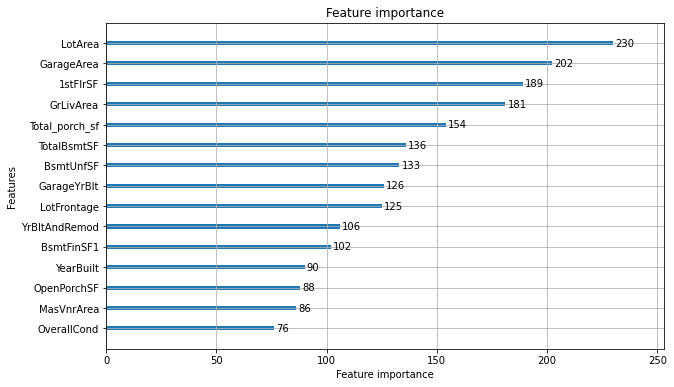

In [33]:
from lightgbm import plot_importance

f, ax = plt.subplots(figsize = (10,6))
plot_importance(lgbm, max_num_features =15, ax= ax)

### Category Type 변경

In [35]:
# Encoder:
categorical_columns = [f for f in features.columns if features[f].dtype == 'object']
print(categorical_columns)

['MSSubClass', 'MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [36]:
for i in enumerate (categorical_columns) :
    ca = i[1] 
    features[ca] = features[ca].astype('category') 

    print(ca)

MSSubClass
MSZoning
Alley
LotShape
LandContour
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
MiscFeature
MoSold
YrSold
SaleType
SaleCondition


In [37]:
final_features = features

In [38]:
X = final_features.iloc[:len(y), :]
#X_sub = final_features.iloc[len(y):, :]
X_test = final_features.iloc[len(y):, :]
X.shape, y.shape, X_test.shape

((1460, 86), (1460,), (1459, 86))

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(1022, 86) (438, 86) (1022,) (438,)


In [40]:
lgbm = LGBMRegressor(n_estimators=500
                      , num_leaves=50
                      , subsample=0.9
                      , min_child_samples=40
                      , max_depth=6
                      )

evals = [(x_test, y_test)]
lgbm.fit(x_train, y_train, early_stopping_rounds=100, eval_set=evals, verbose=True)

[1]	valid_0's l2: 0.145422
Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 0.126132
[3]	valid_0's l2: 0.110414
[4]	valid_0's l2: 0.0975868
[5]	valid_0's l2: 0.0860836
[6]	valid_0's l2: 0.0771779
[7]	valid_0's l2: 0.0697556
[8]	valid_0's l2: 0.0627732
[9]	valid_0's l2: 0.0573542
[10]	valid_0's l2: 0.0524522
[11]	valid_0's l2: 0.0483784
[12]	valid_0's l2: 0.0449741
[13]	valid_0's l2: 0.0419861
[14]	valid_0's l2: 0.0394908
[15]	valid_0's l2: 0.0373446
[16]	valid_0's l2: 0.0353206
[17]	valid_0's l2: 0.0336923
[18]	valid_0's l2: 0.0321861
[19]	valid_0's l2: 0.030886
[20]	valid_0's l2: 0.0296403
[21]	valid_0's l2: 0.0286905
[22]	valid_0's l2: 0.0277327
[23]	valid_0's l2: 0.0270077
[24]	valid_0's l2: 0.0263637
[25]	valid_0's l2: 0.0257883
[26]	valid_0's l2: 0.0252846
[27]	valid_0's l2: 0.0247999
[28]	valid_0's l2: 0.024318
[29]	valid_0's l2: 0.0240222
[30]	valid_0's l2: 0.0237198
[31]	valid_0's l2: 0.0234222
[32]	valid_0's l2: 0.023106
[33]	valid_0's l2: 0.0228

[330]	valid_0's l2: 0.0187882
[331]	valid_0's l2: 0.0188031
[332]	valid_0's l2: 0.0188038
[333]	valid_0's l2: 0.0188271
[334]	valid_0's l2: 0.0188264
[335]	valid_0's l2: 0.0188164
[336]	valid_0's l2: 0.0188087
[337]	valid_0's l2: 0.0188064
[338]	valid_0's l2: 0.0188155
[339]	valid_0's l2: 0.018816
[340]	valid_0's l2: 0.018816
[341]	valid_0's l2: 0.0188062
[342]	valid_0's l2: 0.0188081
[343]	valid_0's l2: 0.0187971
[344]	valid_0's l2: 0.0187975
Early stopping, best iteration is:
[244]	valid_0's l2: 0.0185752


LGBMRegressor(max_depth=6, min_child_samples=40, n_estimators=500,
              num_leaves=50, subsample=0.9)

In [41]:
y_train_pred_x = lgbm.predict(x_train)
y_test_pred_x = lgbm.predict(x_test)

In [42]:
print('rmsle Train = ' + str(rmsle(y_train, y_train_pred_x)))
print('rmsle Test = ' + str(rmsle(y_test, y_test_pred_x)))
print("Mean Absolute Error Train : " + str(mean_absolute_error(y_train, y_train_pred_x)))
print("Mean Absolute Error Test : " + str(mean_absolute_error(y_test, y_test_pred_x)))
print("RMSE Train" , RMSE(y_train ,  y_train_pred_x))
print("RMSE Test" , RMSE(y_test , y_test_pred_x))

rmsle Train = 0.040822407517365794
rmsle Test = 0.13629077751951948
Mean Absolute Error Train : 0.027675830280169147
Mean Absolute Error Test : 0.09051842195675112
RMSE Train 0.0408224075173658
RMSE Test 0.13629077751951948


In [43]:
lgbm.score(x_test, y_test)

0.8894968407176463

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

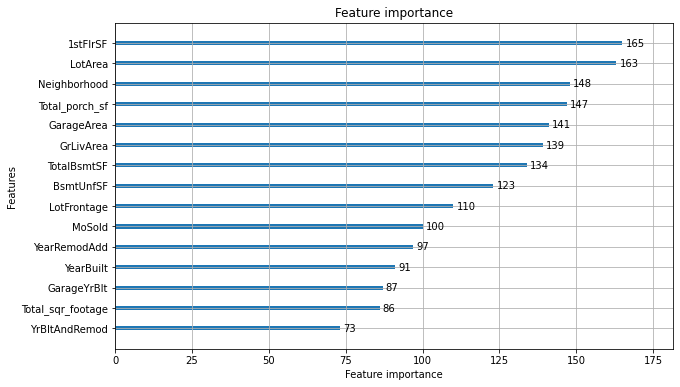

In [44]:
#lgbm.features_importance_
from lightgbm import plot_importance

f, ax = plt.subplots(figsize = (10,6))
plot_importance(lgbm, max_num_features =15, ax= ax)